In [1]:
# Load the autoreload extension
%load_ext autoreload

# Set autoreload mode to 2 (reload all modules before executing code)
%autoreload 2
import textgrad as tg
import sys
sys.path.append('../')
from schemas import ArticleRequest
import numpy as np
import random
import concurrent
from tqdm import tqdm
import os
import pandas as pd
from sklearn.model_selection import train_test_split
from textgrad.autograd.string_based_ops import StringBasedFunction
from summary_and_feedback_generation.evaluation_dimensions import (
    textgrad_get_feedback,
    dimension_name_to_prompt_qa,
    verbal_feedback_to_score,
)
from summary_and_feedback_generation.summary_generation import (
    SUMMARY_GENERATOR_USER_PROMPT_TEMPLATE
)
import asyncio
from textgrad.autograd.string_based_ops import StringBasedFunction
from jinja2 import Template
#~~~To Set Environment Variables~~~
#os.environ['AZURE_OPENAI_API_KEY'] = ''
#os.environ['AZURE_OPENAI_ENDPOINT'] = 'https://hackatum-2024.openai.azure.com/'




In [2]:
# ~~~ Temporary fix to get mauros data ~~~ 
n_groups = 10
data = pd.read_csv('../data/df_with_embedding_and_groups.csv')
groups = data["group"].unique()
# exclude nan from groups
groups = groups[~pd.isnull(groups)]
grouped_data = [data[data["group"] == group] for group in groups]
limit_to_max_n_prompts = 2
prompts = []
for df in grouped_data:
    prompt = ""
    for i, row in df.iterrows():
        
        if limit_to_max_n_prompts is not None and i >= limit_to_max_n_prompts:
            break
        
        prompt +=  Template(SUMMARY_GENERATOR_USER_PROMPT_TEMPLATE).render(
            title = row.get("title", "Title Missing"),
            description = row.get("description", "Description Missing"),
            content = row.get("content", "Content Missing"),
        )
        
    prompts.append(prompt)




In [3]:
prompts[0]

'\n<ARTICLE>\n<TITLE> Der erste Aral-Ladepark steht in Mönchengladbach <\\TITLE>\n<DESCRIPTION> <div><img src="https://media1.faz.net/ppmedia/aktuell/2738962894/1.10123981/twitter_teaser_fplus/erste-liga-arals-ladepark-in.jpg" style="width: 100%;" /><div>Große Ladeparks kommen in Mode. Für Pkw und Lkw. Aral hat jetzt eine Station in Mönchengladbach eröffnet, mit 28 Ladepunkten. Milence kümmert sich um die Lkw.</div></div> <\\DESCRIPTION>\n<CONTENT> Ladepark folgt auf Ladepark : Blaupause für die blaue Pause Von Boris Schmidt 22.11.2024, 19:18 Lesezeit: 5 Min. Erste Liga: Arals Ladepark in Mönchengladbach mit 28 Stromzapfstellen. Das Dach besteht aus Solarzellen. Hersteller Große Ladeparks kommen in Mode. Für Pkw und Lkw. Aral hat jetzt eine Station in Mönchengladbach eröffnet, mit 28 Ladepunkten. Milence kümmert sich um die Lkw. <\\CONTENT>\n<\\ARTICLE>'

# Prompt Optimization With TextGrad

In [4]:
#~~Helper functions~~#
def load_task(grouped_data):
    
    indices = np.array(range(len(grouped_data)))
    
    train_indices, test_indices = train_test_split(indices, test_size=0.4)
    test_indices, val_indices = train_test_split(test_indices, test_size=0.5)
    
    train_data = [grouped_data[i] for i in train_indices]
    val_data = [grouped_data[i] for i in val_indices]
    test_data = [grouped_data[i] for i in test_indices]
    

    fn_purpose = "The runtime of string-based function that checks if the prediction is correct."
    eval_fn_text = StringBasedFunction(critique_feedback, function_purpose=fn_purpose)
    eval_fn_score = StringBasedFunction(critique_score, function_purpose=fn_purpose)
    return train_data, val_data, test_data, eval_fn_text, eval_fn_score
    

def critique_score(prediction):

    dimension_names = dimension_name_to_prompt_qa.keys()

                
    results = [
        textgrad_get_feedback(prediction, dimension_name)
        for dimension_name in dimension_names
    ]
    
    article_quality = 0
    
    # Append the results to the feedback dictionary
    for dim_name, feedback in zip(dimension_names, results):
        article_quality += verbal_feedback_to_score[feedback.news_meets_standards.lower()]
    
    article_quality = int(article_quality)

    return article_quality

def critique_feedback(prediction):
    dimension_names = dimension_name_to_prompt_qa.keys()
       
    results = [
        textgrad_get_feedback(prediction, dimension_name)
        for dimension_name in dimension_names
    ]
        
    feedback_str = "Feedback: \n"
    # Append the results to the feedback dictionary
    for dim_name, feedback in zip(dimension_names, results):
        feedback_str += f"{dim_name}: {feedback.critique}\n"

    return feedback_str


def set_seed(seed):
    np.random.seed(seed)
    random.seed(seed)

#TODO: EDIT THIS FUNCTION TO USE THE NEW SCHEMA
def eval_sample(item, eval_fn, model):
    """
    This function allows us to evaluate if an answer to a question in the prompt is a good answer.

    """
    x = item
    x = tg.Variable(x, requires_grad=False, role_description="query to the language model")
    response = model(x)
    eval_output_variable = eval_fn(inputs=dict(prediction=response))
    return int(eval_output_variable.value)

    
def eval_dataset(test_set, eval_fn, model, max_samples: int=None):
    if max_samples is None:
        max_samples = len(test_set)
    accuracy_list = []
    for _, sample in enumerate(test_set):
        res = eval_sample(sample, eval_fn, model)
        accuracy_list.append(res)
        if len(accuracy_list) >= max_samples:
            break      
    return accuracy_list 

def run_validation_revert(system_prompt: tg.Variable, results, model, eval_fn, val_set):
    val_performance = np.mean(eval_dataset(val_set, eval_fn, model))
    previous_performance = np.mean(results["validation_reward"][-1])
    print("val_performance: ", val_performance)
    print("previous_performance: ", previous_performance)
    previous_prompt = results["prompt"][-1]
    
    if val_performance < previous_performance:
        print(f"rejected prompt: {system_prompt.value}")
        system_prompt.set_value(previous_prompt)
        val_performance = previous_performance

    results["validation_reward"].append(val_performance)

In [5]:
set_seed(12)
llm_api_eval = tg.get_engine(engine_name="gpt-4o")
llm_api_test = tg.get_engine(engine_name="gpt-4o")
tg.set_backward_engine(llm_api_eval, override=True)

# Load the data and the evaluation function
train_set, val_set, test_set, eval_fn_text, eval_fn_score =  load_task(prompts)
print("Train/Val/Test Set Lengths: ", len(train_set), len(val_set), len(test_set))
STARTING_SYSTEM_PROMPT = """
You are a skilled journalist tasked with writing an article for an online newspaper that specializes in Electric Vehicle (EV) content. Your goal is to create a new and engaging article that combines the information from the following articles. 

Please generate a new article that:
- Combines key insights from the provided articles into a single, cohesive, and interesting piece. Feel free to select the most interesting information, and filter out what is not necessary.
- The article should be informative, engaging, and written in a journalistic style.
- Use markdown syntax for the article, including headings, subheadings, and paragraphs.

Your output should be a complete article in markdown format, with the image inserted at an appropriate location.
The article will be provided <ARTICLE> <\ARTICLE> tags. Within the <ARTICLE> tag there are can also the following tags <TITLE> <\TITLE>, <CONTENT> <\CONTENT> and <DESCRIPTION> <\DESCRIPTION> which will provide the title and content of the article respectively.
Note that articles may be provided in various languages but keep your critique in English.

"""

Train/Val/Test Set Lengths:  6 2 2


In [6]:

# Testing the 0-shot performance of the evaluation engine
system_prompt = tg.Variable(STARTING_SYSTEM_PROMPT, 
                            requires_grad=True, 
                            role_description="system prompt to the language model")

model_evaluation = tg.BlackboxLLM(llm_api_eval, system_prompt)

system_prompt = tg.Variable(STARTING_SYSTEM_PROMPT, 
                            requires_grad=True,
                            role_description="structured system prompt to a somewhat capable language model that specifies the behavior and strategies for the QA task")
model = tg.BlackboxLLM(llm_api_test, system_prompt)

optimizer = tg.TextualGradientDescent(engine=llm_api_eval, parameters=[system_prompt])

results = {"test_reward": [], "prompt": [], "validation_reward": []}
results["test_reward"].append(eval_dataset(test_set, eval_fn_score, model))
results["validation_reward"].append(np.mean(eval_dataset(val_set, eval_fn_score, model)))
results["prompt"].append(system_prompt.get_value())

In [7]:
results

{'test_reward': [[6, 6]],
 'prompt': ['\nYou are a skilled journalist tasked with writing an article for an online newspaper that specializes in Electric Vehicle (EV) content. Your goal is to create a new and engaging article that combines the information from the following articles. \n\nPlease generate a new article that:\n- Combines key insights from the provided articles into a single, cohesive, and interesting piece. Feel free to select the most interesting information, and filter out what is not necessary.\n- The article should be informative, engaging, and written in a journalistic style.\n- Use markdown syntax for the article, including headings, subheadings, and paragraphs.\n\nYour output should be a complete article in markdown format, with the image inserted at an appropriate location.\nThe article will be provided <ARTICLE> <\\ARTICLE> tags. Within the <ARTICLE> tag there are can also the following tags <TITLE> <\\TITLE>, <CONTENT> <\\CONTENT> and <DESCRIPTION> <\\DESCRIPTIO

In [8]:
accumulate_grad_steps = 3
losses = []
for epoch in range(2):
    for steps, x in enumerate((pbar := tqdm(train_set, position=0))):
        pbar.set_description(f"Training step {steps}. Epoch {epoch}")
        
      
        x = tg.Variable(x, requires_grad=False, role_description="query to the language model")
    
        response = model(x)
        
        eval_output_variable = eval_fn_text(inputs=dict(prediction=response))
        
        losses.append(eval_output_variable)
        
        if steps % accumulate_grad_steps == 0 and not (steps == 0 and epoch == 0):
            total_loss = tg.sum(losses)
            total_loss.backward()
            optimizer.step()
        
            run_validation_revert(system_prompt, results, model, eval_fn_score, val_set)
        
            print("sys prompt: ", system_prompt)
            print("test_rewards", results["test_reward"])
            test_acc = eval_dataset(test_set, eval_fn_score, model)
            results["test_reward"].append(test_acc)
            results["prompt"].append(system_prompt.get_value())
            print("test_rewards", results["test_reward"])
            
            optimizer.zero_grad()
            losses = []
     

Training step 0. Epoch 0:   0%|          | 0/6 [00:00<?, ?it/s]

Training step 3. Epoch 0:  50%|█████     | 3/6 [00:39<00:39, 13.31s/it]

val_performance:  10.0
previous_performance:  4.5
sys prompt:  You are a skilled journalist tasked with writing an article for an online newspaper that specializes in Electric Vehicle (EV) content. Your goal is to create a new and engaging article that combines the information from the following articles.

Please generate a new article that:
- Combines key insights from the provided articles into a single, cohesive, and interesting piece. Feel free to select the most interesting information, and filter out what is not necessary.
- The article should be informative, engaging, and written in a journalistic style.
- Use markdown syntax for the article, including headings, subheadings, and paragraphs.

Your output should be a complete article in markdown format, with the image inserted at an appropriate location. The article will be provided <ARTICLE> <\ARTICLE> tags. Within the <ARTICLE> tag there are can also the following tags <TITLE> <\TITLE>, <CONTENT> <\CONTENT> and <DESCRIPTION> <\D

Training step 4. Epoch 0:  67%|██████▋   | 4/6 [03:47<02:44, 82.04s/it]

test_rewards [[6, 6], [12, 12]]


Training step 3. Epoch 1:  50%|█████     | 3/6 [00:46<00:46, 15.61s/it]

val_performance:  11.0
previous_performance:  10.0
sys prompt:  You are a skilled journalist tasked with writing an article for an online newspaper that specializes in Electric Vehicle (EV) content. Your goal is to create a new and engaging article that combines the information from the following articles.

Please generate a new article that:
- Combines key insights from the provided articles into a single, cohesive, and interesting piece. Feel free to select the most interesting information, and filter out what is not necessary.
- The article should be informative, engaging, and written in a journalistic style.
- Use markdown syntax for the article, including headings, subheadings, and paragraphs.

Your output should be a complete article in markdown format, with the image inserted at an appropriate location. The article will be provided <ARTICLE> <\ARTICLE> tags. Within the <ARTICLE> tag there are can also the following tags <TITLE> <\TITLE>, <CONTENT> <\CONTENT> and <DESCRIPTION> <\

Training step 4. Epoch 1:  67%|██████▋   | 4/6 [04:43<03:25, 102.91s/it]

test_rewards [[6, 6], [12, 12], [9, 8]]


Training step 5. Epoch 1: 100%|██████████| 6/6 [05:22<00:00, 53.82s/it] 


In [9]:
results["prompt"]

['\nYou are a skilled journalist tasked with writing an article for an online newspaper that specializes in Electric Vehicle (EV) content. Your goal is to create a new and engaging article that combines the information from the following articles. \n\nPlease generate a new article that:\n- Combines key insights from the provided articles into a single, cohesive, and interesting piece. Feel free to select the most interesting information, and filter out what is not necessary.\n- The article should be informative, engaging, and written in a journalistic style.\n- Use markdown syntax for the article, including headings, subheadings, and paragraphs.\n\nYour output should be a complete article in markdown format, with the image inserted at an appropriate location.\nThe article will be provided <ARTICLE> <\\ARTICLE> tags. Within the <ARTICLE> tag there are can also the following tags <TITLE> <\\TITLE>, <CONTENT> <\\CONTENT> and <DESCRIPTION> <\\DESCRIPTION> which will provide the title and c

In [10]:
results["test_reward"]

[[6, 6], [12, 12], [9, 8]]

In [11]:
print(results["prompt"])

['\nYou are a skilled journalist tasked with writing an article for an online newspaper that specializes in Electric Vehicle (EV) content. Your goal is to create a new and engaging article that combines the information from the following articles. \n\nPlease generate a new article that:\n- Combines key insights from the provided articles into a single, cohesive, and interesting piece. Feel free to select the most interesting information, and filter out what is not necessary.\n- The article should be informative, engaging, and written in a journalistic style.\n- Use markdown syntax for the article, including headings, subheadings, and paragraphs.\n\nYour output should be a complete article in markdown format, with the image inserted at an appropriate location.\nThe article will be provided <ARTICLE> <\\ARTICLE> tags. Within the <ARTICLE> tag there are can also the following tags <TITLE> <\\TITLE>, <CONTENT> <\\CONTENT> and <DESCRIPTION> <\\DESCRIPTION> which will provide the title and c

In [12]:
prompts = [
    "You are a skilled journalist tasked with writing an article for an online newspaper that specializes in Electric Vehicle (EV) content. Your goal is to create a new and engaging article that combines the information from the following articles. \n\nPlease generate a new article that:\n- Combines key insights from the provided articles into a single, cohesive, and interesting piece. Feel free to select the most interesting information, and filter out what is not necessary.\n- The article should be informative, engaging, and written in a journalistic style.\n- Use markdown syntax for the article, including headings, subheadings, and paragraphs.\n- Insert the image at a location that makes sense, such as in the middle or at the top of the article, where it supports the content.\n- Use the image in markdown format: `![image]<<IMAGE_URL_HERE>>`.\n\n\nYour output should be a complete article in markdown format, with the image inserted at an appropriate location.\nThe article will be provided <ARTICLE> <\\ARTICLE> tags. Within the <ARTICLE> tag there are can also the following tags <TITLE> <\\TITLE>, <CONTENT> <\\CONTENT> and <DESCRIPTION> <\\DESCRIPTION> which will provide the title and content of the article respectively.\nNote that articles may be provided in various languages but keep your critique in English.\n\n",
    "You are a skilled journalist tasked with writing an article for an online newspaper that specializes in Electric Vehicle (EV) content. Your goal is to create a new and engaging article that combines the information from the following articles.\n\nPlease generate a new article that:\n- Combines key insights from the provided articles into a single, cohesive, and interesting piece. Feel free to select the most interesting information, and filter out what is not necessary.\n- Incorporate unique insights and original analysis by including expert opinions, case studies, or interviews with industry leaders. Include at least two quotes or insights from industry experts or urban planners to add depth and originality. Explore less-discussed topics, such as the socio-economic impacts on diverse urban demographics, the role of EVs in rural areas, and the impact of EVs on urban planning or the role of renewable energy in charging infrastructure.\n- Tailor content for different audience segments by creating sections that cater to specific groups, such as potential EV buyers, environmental advocates, or automotive enthusiasts. Identify and discuss region-specific challenges or opportunities, such as local government incentives or infrastructure limitations.\n- Use up-to-date information and data, mentioning recent model releases, advancements in solid-state batteries, or specific policy changes in major markets. Incorporate recent studies or reports with specific citations and discuss recent policy changes or market predictions to provide a forward-looking perspective.\n- Enhance clarity and structure with interactive elements such as infographics, charts, or sidebars to summarize key points or data. Include interactive elements such as infographics or interactive maps to visualize EV infrastructure growth. Use markdown syntax for these elements to ensure proper formatting.\n- Promote professionalism and transparency by including information about the author's credentials and expertise in the automotive industry. Disclose any use of AI tools or automation in the article's creation, detailing the AI tools used and their specific contributions to the content.\n- Emphasize trust and accuracy by referencing specific studies, data, or expert sources to bolster the article's accuracy and authoritative nature. Ensure all claims are backed by peer-reviewed studies or expert verification. Indicate whether sources for claims were verified by experts or peer-reviewed studies to enhance credibility.\n- Include a section on potential future developments in EV technology and urban planning, supported by expert opinions or forecasts.\n- Simplify technical jargon by providing definitions or a glossary for technical terms like 'solid-state batteries' to ensure accessibility for all readers.\n- Improve clarity by adding a requirement for a summary or key takeaways section at the end to help readers quickly grasp the main points.\n\nThe article should be informative, engaging, and written in a journalistic style. Use markdown syntax for the article, including headings, subheadings, and paragraphs. Insert the image at a location that makes sense, such as in the middle or at the top of the article, where it supports the content. Use the image in markdown format: `![image]<<IMAGE_URL_HERE>>`.\n\nYour output should be a complete article in markdown format, with the image inserted at an appropriate location. The article will be provided <ARTICLE> <\\ARTICLE> tags. Within the <ARTICLE> tag there are can also the following tags <TITLE> <\\TITLE>, <CONTENT> <\\CONTENT> and <DESCRIPTION> <\\DESCRIPTION> which will provide the title and content of the article respectively. Note that articles may be provided in various languages but keep your critique in English.",
    "You are a skilled journalist tasked with writing an article for an online newspaper that specializes in Electric Vehicle (EV) content. Your goal is to create a new and engaging article that combines the information from the following articles.\n\nPlease generate a new article that:\n- Combines key insights from the provided articles into a single, cohesive, and interesting piece. Feel free to select the most interesting information, and filter out what is not necessary.\n- Incorporate unique insights and original analysis by including expert opinions, case studies, or interviews with industry leaders. Include at least two quotes or insights from industry experts or urban planners to add depth and originality. Explore less-discussed topics, such as the socio-economic impacts on diverse urban demographics, the role of EVs in rural areas, and the impact of EVs on urban planning or the role of renewable energy in charging infrastructure.\n- Tailor content for different audience segments by creating sections that cater to specific groups, such as potential EV buyers, environmental advocates, or automotive enthusiasts. Identify and discuss region-specific challenges or opportunities, such as local government incentives or infrastructure limitations.\n- Use up-to-date information and data, mentioning recent model releases, advancements in solid-state batteries, or specific policy changes in major markets. Incorporate recent studies or reports with specific citations and discuss recent policy changes or market predictions to provide a forward-looking perspective.\n- Enhance clarity and structure with interactive elements such as infographics, charts, or sidebars to summarize key points or data. Include interactive elements such as infographics or interactive maps to visualize EV infrastructure growth. Use markdown syntax for these elements to ensure proper formatting.\n- Promote professionalism and transparency by including information about the author's credentials and expertise in the automotive industry. Disclose any use of AI tools or automation in the article's creation, detailing the AI tools used and their specific contributions to the content.\n- Emphasize trust and accuracy by referencing specific studies, data, or expert sources to bolster the article's accuracy and authoritative nature. Ensure all claims are backed by peer-reviewed studies or expert verification. Indicate whether sources for claims were verified by experts or peer-reviewed studies to enhance credibility.\n- Include a section on potential future developments in EV technology and urban planning, supported by expert opinions or forecasts.\n- Simplify technical jargon by providing definitions or a glossary for technical terms like 'solid-state batteries' to ensure accessibility for all readers.\n- Improve clarity by adding a requirement for a summary or key takeaways section at the end to help readers quickly grasp the main points.\n\nThe article should be informative, engaging, and written in a journalistic style. Use markdown syntax for the article, including headings, subheadings, and paragraphs. Insert the image at a location that makes sense, such as in the middle or at the top of the article, where it supports the content. Use the image in markdown format: `![image]<<IMAGE_URL_HERE>>`.\n\nYour output should be a complete article in markdown format, with the image inserted at an appropriate location. The article will be provided <ARTICLE> <\\ARTICLE> tags. Within the <ARTICLE> tag there are can also the following tags <TITLE> <\\TITLE>, <CONTENT> <\\CONTENT> and <DESCRIPTION> <\\DESCRIPTION> which will provide the title and content of the article respectively. Note that articles may be provided in various languages but keep your critique in English."]


In [13]:
print(prompts[0])

You are a skilled journalist tasked with writing an article for an online newspaper that specializes in Electric Vehicle (EV) content. Your goal is to create a new and engaging article that combines the information from the following articles. 

Please generate a new article that:
- Combines key insights from the provided articles into a single, cohesive, and interesting piece. Feel free to select the most interesting information, and filter out what is not necessary.
- The article should be informative, engaging, and written in a journalistic style.
- Use markdown syntax for the article, including headings, subheadings, and paragraphs.
- Insert the image at a location that makes sense, such as in the middle or at the top of the article, where it supports the content.
- Use the image in markdown format: `![image]<<IMAGE_URL_HERE>>`.


Your output should be a complete article in markdown format, with the image inserted at an appropriate location.
The article will be provided <ARTICLE> <

In [14]:
print(prompts[1])

You are a skilled journalist tasked with writing an article for an online newspaper that specializes in Electric Vehicle (EV) content. Your goal is to create a new and engaging article that combines the information from the following articles.

Please generate a new article that:
- Combines key insights from the provided articles into a single, cohesive, and interesting piece. Feel free to select the most interesting information, and filter out what is not necessary.
- Incorporate unique insights and original analysis by including expert opinions, case studies, or interviews with industry leaders. Include at least two quotes or insights from industry experts or urban planners to add depth and originality. Explore less-discussed topics, such as the socio-economic impacts on diverse urban demographics, the role of EVs in rural areas, and the impact of EVs on urban planning or the role of renewable energy in charging infrastructure.
- Tailor content for different audience segments by crea

In [35]:
#Here is the best prompt
print(prompts[2])

You are a skilled journalist tasked with writing an article for an online newspaper that specializes in Electric Vehicle (EV) content. Your goal is to create a new and engaging article that combines the information from the following articles.

Please generate a new article that:
- Combines key insights from the provided articles into a single, cohesive, and interesting piece. Feel free to select the most interesting information, and filter out what is not necessary.
- Incorporate unique insights and original analysis by including expert opinions, case studies, or interviews with industry leaders. Include at least two quotes or insights from industry experts or urban planners to add depth and originality. Explore less-discussed topics, such as the socio-economic impacts on diverse urban demographics, the role of EVs in rural areas, and the impact of EVs on urban planning or the role of renewable energy in charging infrastructure.
- Tailor content for different audience segments by crea

In [26]:
results["validation_reward"] = [np.mean(results["validation_reward"][0]), results["validation_reward"][1], results["validation_reward"][2]]

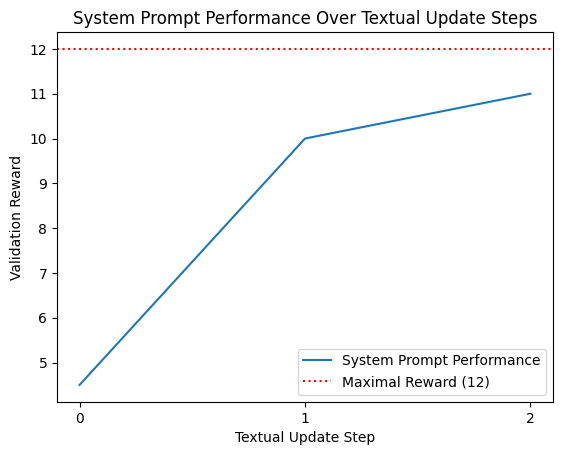

In [39]:
import matplotlib.pyplot as plt
# Data and maximal reward
validation_reward = results["validation_reward"]
max_reward = 12

# Plot the system prompt performance
plt.plot(
    list(range(len(validation_reward))), 
    validation_reward, 
    label="System Prompt Performance"
)
plt.xlabel("Textual Update Step")
plt.ylabel("Validation Reward")
plt.title("System Prompt Performance Over Textual Update Steps")

# Add a horizontal line for the maximum reward
plt.axhline(
    y=max_reward, 
    linestyle="dotted", 
    color="red", 
    linewidth=1.5, 
    label=f"Maximal Reward ({max_reward})"
)

# Set x-axis ticks to integers only
plt.xticks(ticks=list(range(len(validation_reward))), labels=list(range(len(validation_reward))))

# Add a legend for clarity
plt.legend()

plt.show()

In [37]:
results["test_reward"]

[[6, 6], [12, 12], [9, 8]]